The purpose of this notebook is to create the baseline model.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import metric_functions as mf

Using TensorFlow backend.


In [1]:
pip install Pillow --user

     |████████████████████████████████| 2.1MB 1.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras --user

     |████████████████████████████████| 378kB 750kB/s eta 0:00:01
     |████████████████████████████████| 276kB 976kB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn --user

     |████████████████████████████████| 7.3MB 954kB/s eta 0:00:01
     |████████████████████████████████| 307kB 1.1MB/s eta 0:00:01
Failed to build sklearn
    Running setup.py install for sklearn ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Compile and Create Data <a id='data'></a>

## Identify Working Directory

In [2]:
working_directory = 'mixed_frames_remove_20'

In [3]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 6313 images in the Train set
There are 1852 images in the Test set


There are 1916 MCU images in the train set
There are 4397 non-MCU images in the train set
There are 478 MCU images in the test set
There are 1374 non-MCU images in the test set


# 20% Removal


### Create input data with image size of 128 x 128

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_r20 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 5051,
    color_mode = 'grayscale',
    subset = 'training')

val_generator_r20 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1262,
    color_mode = 'grayscale',
    subset = 'validation')

Found 5051 images belonging to 2 classes.
Found 1262 images belonging to 2 classes.


In [6]:
test_generator_r20 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 1852)

Found 1852 images belonging to 2 classes.


In [8]:
class_labels = ['Non-MCU', 'MCU']
train_images_r20, train_labels_r20 = next(train_generator_r20)
val_images_r20, val_labels_r20 = next(val_generator_r20)
test_images_r20, test_labels_r20 = next(test_generator_r20)
train_y_r20 = np.reshape(train_labels_r20[:,0], (5051,1))
val_y_r20 = np.reshape(val_labels_r20[:,0], (1262,1))
test_y_r20 = np.reshape(test_labels_r20[:,0], (1852,1))
print ("train_images shape: " + str(train_images_r20.shape))
print ("train_labels shape: " + str(train_labels_r20.shape))
print ("val_images shape: " + str(val_images_r20.shape))
print ("val_labels shape: " + str(val_labels_r20.shape))
print ("test_images shape: " + str(test_images_r20.shape))
print ("test_labels shape: " + str(test_labels_r20.shape))

train_images shape: (5051, 128, 128, 1)
train_labels shape: (5051, 2)
val_images shape: (1262, 128, 128, 1)
val_labels shape: (1262, 2)
test_images shape: (1852, 128, 128, 1)
test_labels shape: (1852, 2)


In [9]:
model_r20_4x4 = models.Sequential()
model_r20_4x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r20_4x4.add(layers.MaxPooling2D((2, 2)))

model_r20_4x4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r20_4x4.add(layers.MaxPooling2D((2, 2)))

model_r20_4x4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r20_4x4.add(layers.MaxPooling2D((2, 2)))

model_r20_4x4.add(layers.Flatten())
model_r20_4x4.add(layers.Dense(64, activation='relu'))
model_r20_4x4.add(layers.Dense(1, activation='sigmoid'))

model_r20_4x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [10]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r20_4x4 = model_r20_4x4.fit(train_images_r20,
                                    train_y_r20,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r20, val_y_r20),
                                    callbacks=early_stopping)

Train on 5051 samples, validate on 1262 samples
Epoch 1/50
5051/5051 [==============================] - 9s 2ms/step - loss: 0.6797 - acc: 0.6894 - val_loss: 0.5580 - val_acc: 0.6965
Epoch 2/50
5051/5051 [==============================] - 8s 1ms/step - loss: 0.5746 - acc: 0.6965 - val_loss: 0.6205 - val_acc: 0.6965
Epoch 3/50
5051/5051 [==============================] - 7s 1ms/step - loss: 0.5314 - acc: 0.7034 - val_loss: 2.0900 - val_acc: 0.6965
Epoch 4/50
5051/5051 [==============================] - 8s 1ms/step - loss: 0.5191 - acc: 0.7464 - val_loss: 0.5317 - val_acc: 0.7425
Epoch 5/50
5051/5051 [==============================] - 8s 1ms/step - loss: 0.4571 - acc: 0.7834 - val_loss: 0.5200 - val_acc: 0.7338
Epoch 6/50
5051/5051 [==============================] - 8s 2ms/step - loss: 0.4259 - acc: 0.8052 - val_loss: 0.5319 - val_acc: 0.7258
Epoch 7/50
5051/5051 [==============================] - 8s 2ms/step - loss: 0.3827 - acc: 0.8361 - val_loss: 0.6206 - val_acc: 0.7647
Epoch 8/50
505

Accuracy 
 Train: 0.855, Test: 0.783
Loss 
 Train: 0.296, Test: 0.754 



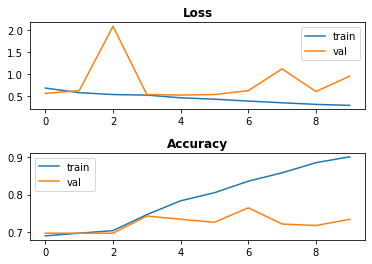



Confusion Matrix, without normalization


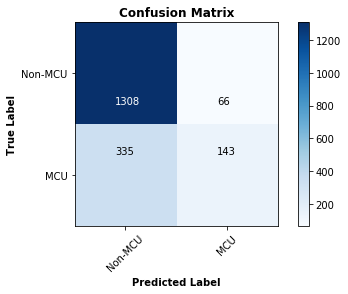



              precision    recall  f1-score   support

     Non-MCU       0.80      0.95      0.87      1374
         MCU       0.68      0.30      0.42       478

    accuracy                           0.78      1852
   macro avg       0.74      0.63      0.64      1852
weighted avg       0.77      0.78      0.75      1852



In [12]:
print(mf.evaluate_test(model_r20_4x4, history_r20_4x4, class_labels, train_images_r20, test_images_r20, train_y_r20, test_y_r20))

### 5x5

In [13]:
model_r20_5x5 = models.Sequential()
model_r20_5x5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Flatten())
model_r20_5x5.add(layers.Dense(64, activation='relu'))
model_r20_5x5.add(layers.Dense(1, activation='sigmoid'))

model_r20_5x5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [14]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r20_5x5 = model_r20_5x5.fit(train_images_r20,
                                    train_y_r20,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r20, val_y_r20),
                                    callbacks=early_stopping)

Train on 5051 samples, validate on 1262 samples
Epoch 1/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.6239 - acc: 0.6937 - val_loss: 0.6174 - val_acc: 0.6965
Epoch 2/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5923 - acc: 0.6965 - val_loss: 0.7336 - val_acc: 0.6965
Epoch 3/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5665 - acc: 0.7052 - val_loss: 0.6665 - val_acc: 0.6165
Epoch 4/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5356 - acc: 0.7327 - val_loss: 0.6192 - val_acc: 0.7266
Epoch 5/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5050 - acc: 0.7553 - val_loss: 1.2659 - val_acc: 0.6965
Epoch 6/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.4732 - acc: 0.7852 - val_loss: 0.5783 - val_acc: 0.7116
Epoch 7/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.4317 - acc: 0.7949 - val_loss: 1.0090 - val_acc: 0.6965
Epoch 8/50
505

Accuracy 
 Train: 0.933, Test: 0.816
Loss 
 Train: 0.155, Test: 0.757 



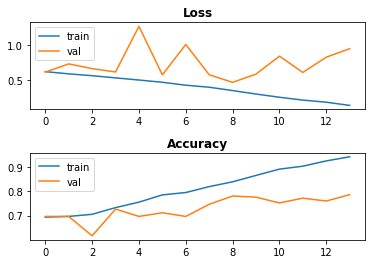



Confusion Matrix, without normalization


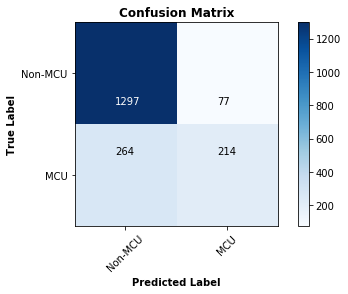



              precision    recall  f1-score   support

     Non-MCU       0.83      0.94      0.88      1374
         MCU       0.74      0.45      0.56       478

    accuracy                           0.82      1852
   macro avg       0.78      0.70      0.72      1852
weighted avg       0.81      0.82      0.80      1852



In [15]:
print(mf.evaluate_test(model_r20_5x5, history_r20_5x5, class_labels, train_images_r20, test_images_r20, train_y_r20, test_y_r20))

### 6x6

In [16]:
model_r20_6x6 = models.Sequential()
model_r20_6x6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Flatten())
model_r20_6x6.add(layers.Dense(64, activation='relu'))
model_r20_6x6.add(layers.Dense(1, activation='sigmoid'))

model_r20_6x6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [17]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r20_6x6 = model_r20_6x6.fit(train_images_r20,
                                    train_y_r20,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r20, val_y_r20),
                                    callbacks=early_stopping)

Train on 5051 samples, validate on 1262 samples
Epoch 1/50
5051/5051 [==============================] - 7s 1ms/step - loss: 0.6231 - acc: 0.6937 - val_loss: 0.6412 - val_acc: 0.6965
Epoch 2/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5958 - acc: 0.6965 - val_loss: 0.7197 - val_acc: 0.6965
Epoch 3/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5857 - acc: 0.6953 - val_loss: 0.5622 - val_acc: 0.6965
Epoch 4/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5700 - acc: 0.6979 - val_loss: 0.6218 - val_acc: 0.6965
Epoch 5/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5392 - acc: 0.7284 - val_loss: 0.5872 - val_acc: 0.7282
Epoch 6/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5194 - acc: 0.7551 - val_loss: 0.8620 - val_acc: 0.6965
Epoch 7/50
5051/5051 [==============================] - 6s 1ms/step - loss: 0.5002 - acc: 0.7585 - val_loss: 0.9381 - val_acc: 0.6965
Epoch 8/50
505

Accuracy 
 Train: 0.871, Test: 0.779
Loss 
 Train: 0.304, Test: 0.537 



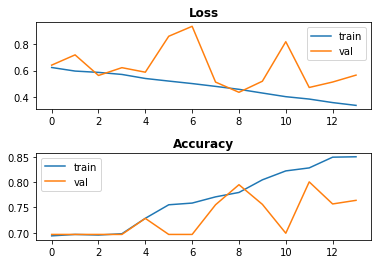



Confusion Matrix, without normalization


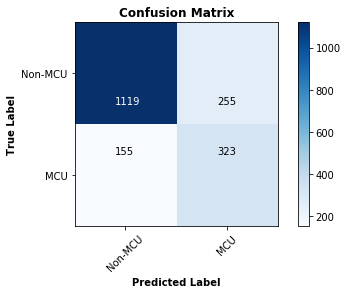



              precision    recall  f1-score   support

     Non-MCU       0.88      0.81      0.85      1374
         MCU       0.56      0.68      0.61       478

    accuracy                           0.78      1852
   macro avg       0.72      0.75      0.73      1852
weighted avg       0.80      0.78      0.78      1852



In [19]:
print(mf.evaluate_test(model_r20_6x6, history_r20_6x6, class_labels, train_images_r20, test_images_r20, train_y_r20, test_y_r20))

# 40% Removal

In [21]:
working_directory = 'mixed_frames_remove_40'

In [22]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 5214 images in the Train set
There are 1852 images in the Test set


There are 1916 MCU images in the train set
There are 3298 non-MCU images in the train set
There are 478 MCU images in the test set
There are 1374 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_r40 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 4172,
    color_mode = 'grayscale',
    subset = 'training')

val_generator_r40 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1042,
    color_mode = 'grayscale',
    subset = 'validation')

Found 4172 images belonging to 2 classes.
Found 1042 images belonging to 2 classes.


In [25]:
test_generator_r40 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 1852)

Found 1852 images belonging to 2 classes.


In [27]:
class_labels = ['Non-MCU', 'MCU']
train_images_r40, train_labels_r40 = next(train_generator_r40)
val_images_r40, val_labels_r40 = next(val_generator_r40)
test_images_r40, test_labels_r40 = next(test_generator_r40)
train_y_r40 = np.reshape(train_labels_r40[:,0], (4172,1))
val_y_r40 = np.reshape(val_labels_r40[:,0], (1042,1))
test_y_r40 = np.reshape(test_labels_r40[:,0], (1852,1))
print ("train_images shape: " + str(train_images_r40.shape))
print ("train_labels shape: " + str(train_labels_r40.shape))
print ("val_images shape: " + str(val_images_r40.shape))
print ("val_labels shape: " + str(val_labels_r40.shape))
print ("test_images shape: " + str(test_images_r40.shape))
print ("test_labels shape: " + str(test_labels_r40.shape))

train_images shape: (4172, 128, 128, 1)
train_labels shape: (4172, 2)
val_images shape: (1042, 128, 128, 1)
val_labels shape: (1042, 2)
test_images shape: (1852, 128, 128, 1)
test_labels shape: (1852, 2)


In [28]:
model_r40_4x4 = models.Sequential()
model_r40_4x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r40_4x4.add(layers.MaxPooling2D((2, 2)))

model_r40_4x4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r40_4x4.add(layers.MaxPooling2D((2, 2)))

model_r40_4x4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r40_4x4.add(layers.MaxPooling2D((2, 2)))

model_r40_4x4.add(layers.Flatten())
model_r40_4x4.add(layers.Dense(64, activation='relu'))
model_r40_4x4.add(layers.Dense(1, activation='sigmoid'))

model_r40_4x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [29]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r40_4x4 = model_r40_4x4.fit(train_images_r40,
                                    train_y_r40,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r40, val_y_r40),
                                    callbacks=early_stopping)

Train on 4172 samples, validate on 1042 samples
Epoch 1/50
4172/4172 [==============================] - 7s 2ms/step - loss: 0.7005 - acc: 0.6203 - val_loss: 0.6382 - val_acc: 0.6392
Epoch 2/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6363 - acc: 0.6433 - val_loss: 0.6213 - val_acc: 0.6660
Epoch 3/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6061 - acc: 0.6733 - val_loss: 0.5461 - val_acc: 0.7025
Epoch 4/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5649 - acc: 0.7047 - val_loss: 0.5309 - val_acc: 0.7207
Epoch 5/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5158 - acc: 0.7433 - val_loss: 0.5652 - val_acc: 0.6900
Epoch 6/50
4172/4172 [==============================] - 6s 2ms/step - loss: 0.4566 - acc: 0.7756 - val_loss: 0.6063 - val_acc: 0.6545
Epoch 7/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.4038 - acc: 0.8133 - val_loss: 0.5405 - val_acc: 0.7399
Epoch 8/50
417

Accuracy 
 Train: 0.937, Test: 0.759
Loss 
 Train: 0.167, Test: 0.597 



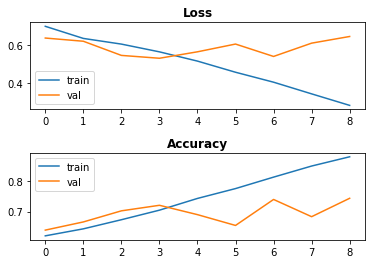



Confusion Matrix, without normalization


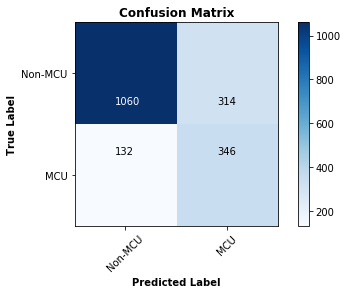



              precision    recall  f1-score   support

     Non-MCU       0.89      0.77      0.83      1374
         MCU       0.52      0.72      0.61       478

    accuracy                           0.76      1852
   macro avg       0.71      0.75      0.72      1852
weighted avg       0.80      0.76      0.77      1852



In [31]:
print(mf.evaluate_test(model_r40_4x4, history_r40_4x4, class_labels, train_images_r40, test_images_r40, train_y_r40, test_y_r40))

### 5x5

In [32]:
model_r40_5x5 = models.Sequential()
model_r40_5x5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Flatten())
model_r40_5x5.add(layers.Dense(64, activation='relu'))
model_r40_5x5.add(layers.Dense(1, activation='sigmoid'))

model_r40_5x5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [33]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r40_5x5 = model_r40_5x5.fit(train_images_r40,
                                    train_y_r40,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r40, val_y_r40),
                                    callbacks=early_stopping)

Train on 4172 samples, validate on 1042 samples
Epoch 1/50
4172/4172 [==============================] - 7s 2ms/step - loss: 0.6632 - acc: 0.6270 - val_loss: 0.6301 - val_acc: 0.6257
Epoch 2/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6429 - acc: 0.6321 - val_loss: 0.6442 - val_acc: 0.6334
Epoch 3/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6214 - acc: 0.6455 - val_loss: 0.5824 - val_acc: 0.6996
Epoch 4/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5939 - acc: 0.6743 - val_loss: 0.5504 - val_acc: 0.7207
Epoch 5/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5666 - acc: 0.7049 - val_loss: 0.5964 - val_acc: 0.7284
Epoch 6/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5250 - acc: 0.7373 - val_loss: 0.5623 - val_acc: 0.7284
Epoch 7/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.4861 - acc: 0.7608 - val_loss: 0.5041 - val_acc: 0.7658
Epoch 8/50
417

Accuracy 
 Train: 0.894, Test: 0.788
Loss 
 Train: 0.240, Test: 0.662 



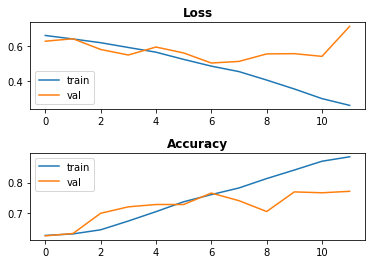



Confusion Matrix, without normalization


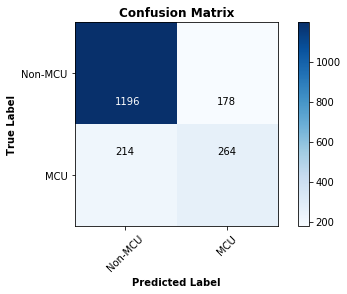



              precision    recall  f1-score   support

     Non-MCU       0.85      0.87      0.86      1374
         MCU       0.60      0.55      0.57       478

    accuracy                           0.79      1852
   macro avg       0.72      0.71      0.72      1852
weighted avg       0.78      0.79      0.79      1852



In [34]:
print(mf.evaluate_test(model_r40_5x5, history_r40_5x5, class_labels, train_images_r40, test_images_r40, train_y_r40, test_y_r40))

### 6x6

In [35]:
model_r40_6x6 = models.Sequential()
model_r40_6x6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Flatten())
model_r40_6x6.add(layers.Dense(64, activation='relu'))
model_r40_6x6.add(layers.Dense(1, activation='sigmoid'))

model_r40_6x6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [36]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r40_6x6 = model_r40_6x6.fit(train_images_r40,
                                    train_y_r40,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r40, val_y_r40),
                                    callbacks=early_stopping)

Train on 4172 samples, validate on 1042 samples
Epoch 1/50
4172/4172 [==============================] - 7s 2ms/step - loss: 0.6687 - acc: 0.6323 - val_loss: 0.6026 - val_acc: 0.6324
Epoch 2/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6383 - acc: 0.6309 - val_loss: 0.5892 - val_acc: 0.6324
Epoch 3/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6288 - acc: 0.6345 - val_loss: 0.5899 - val_acc: 0.6324
Epoch 4/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.6144 - acc: 0.6584 - val_loss: 0.6276 - val_acc: 0.6929
Epoch 5/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5903 - acc: 0.6908 - val_loss: 0.5452 - val_acc: 0.7303
Epoch 6/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5561 - acc: 0.7246 - val_loss: 0.5471 - val_acc: 0.7284
Epoch 7/50
4172/4172 [==============================] - 6s 1ms/step - loss: 0.5217 - acc: 0.7423 - val_loss: 0.5629 - val_acc: 0.7207
Epoch 8/50
417

Accuracy 
 Train: 0.926, Test: 0.761
Loss 
 Train: 0.184, Test: 0.775 



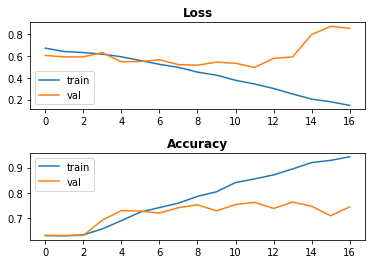



Confusion Matrix, without normalization


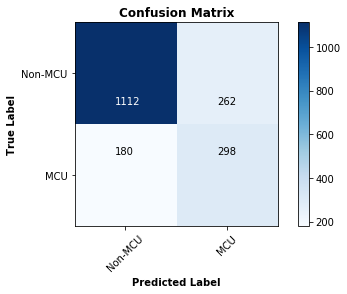



              precision    recall  f1-score   support

     Non-MCU       0.86      0.81      0.83      1374
         MCU       0.53      0.62      0.57       478

    accuracy                           0.76      1852
   macro avg       0.70      0.72      0.70      1852
weighted avg       0.78      0.76      0.77      1852



In [37]:
print(mf.evaluate_test(model_r40_6x6, history_r40_6x6, class_labels, train_images_r40, test_images_r40, train_y_r40, test_y_r40))

# 60% Removal

In [38]:
working_directory = 'mixed_frames_remove_60'

In [39]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 4115 images in the Train set
There are 1852 images in the Test set


There are 1916 MCU images in the train set
There are 2199 non-MCU images in the train set
There are 478 MCU images in the test set
There are 1374 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_r60 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 3293,
    color_mode = 'grayscale',
    subset = 'training')

val_generator_r60 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 822,
    color_mode = 'grayscale',
    subset = 'validation')

Found 3293 images belonging to 2 classes.
Found 822 images belonging to 2 classes.


In [41]:
test_generator_r60 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 1852)

Found 1852 images belonging to 2 classes.


In [42]:
class_labels = ['Non-MCU', 'MCU']
train_images_r60, train_labels_r60 = next(train_generator_r60)
val_images_r60, val_labels_r60 = next(val_generator_r60)
test_images_r60, test_labels_r60 = next(test_generator_r60)
train_y_r60 = np.reshape(train_labels_r60[:,0], (3293,1))
val_y_r60 = np.reshape(val_labels_r60[:,0], (822,1))
test_y_r60 = np.reshape(test_labels_r60[:,0], (1852,1))
print ("train_images shape: " + str(train_images_r60.shape))
print ("train_labels shape: " + str(train_labels_r60.shape))
print ("val_images shape: " + str(val_images_r60.shape))
print ("val_labels shape: " + str(val_labels_r60.shape))
print ("test_images shape: " + str(test_images_r60.shape))
print ("test_labels shape: " + str(test_labels_r60.shape))

train_images shape: (3293, 128, 128, 1)
train_labels shape: (3293, 2)
val_images shape: (822, 128, 128, 1)
val_labels shape: (822, 2)
test_images shape: (1852, 128, 128, 1)
test_labels shape: (1852, 2)


In [43]:
model_r60_4x4 = models.Sequential()
model_r60_4x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r60_4x4.add(layers.MaxPooling2D((2, 2)))

model_r60_4x4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r60_4x4.add(layers.MaxPooling2D((2, 2)))

model_r60_4x4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r60_4x4.add(layers.MaxPooling2D((2, 2)))

model_r60_4x4.add(layers.Flatten())
model_r60_4x4.add(layers.Dense(64, activation='relu'))
model_r60_4x4.add(layers.Dense(1, activation='sigmoid'))

model_r60_4x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [44]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r60_4x4 = model_r60_4x4.fit(train_images_r60,
                                    train_y_r60,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r60, val_y_r60),
                                    callbacks=early_stopping)

Train on 3293 samples, validate on 822 samples
Epoch 1/50
3293/3293 [==============================] - 5s 2ms/step - loss: 0.7077 - acc: 0.5199 - val_loss: 0.6861 - val_acc: 0.5669
Epoch 2/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6955 - acc: 0.5800 - val_loss: 0.6727 - val_acc: 0.5815
Epoch 3/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6548 - acc: 0.6155 - val_loss: 0.6037 - val_acc: 0.6752
Epoch 4/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6057 - acc: 0.6720 - val_loss: 0.6877 - val_acc: 0.5925
Epoch 5/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.5641 - acc: 0.7124 - val_loss: 0.5644 - val_acc: 0.7178
Epoch 6/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.5007 - acc: 0.7616 - val_loss: 0.6413 - val_acc: 0.7105
Epoch 7/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.4499 - acc: 0.7974 - val_loss: 0.5413 - val_acc: 0.7311
Epoch 8/50
3293

Accuracy 
 Train: 0.975, Test: 0.760
Loss 
 Train: 0.077, Test: 0.853 



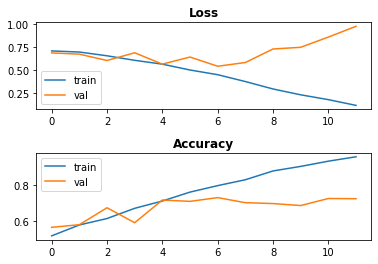



Confusion Matrix, without normalization


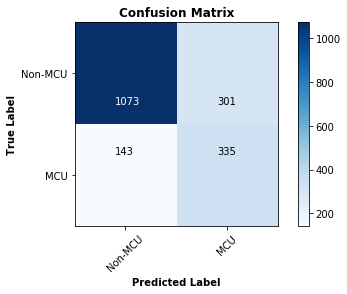



              precision    recall  f1-score   support

     Non-MCU       0.88      0.78      0.83      1374
         MCU       0.53      0.70      0.60       478

    accuracy                           0.76      1852
   macro avg       0.70      0.74      0.72      1852
weighted avg       0.79      0.76      0.77      1852



In [45]:
print(mf.evaluate_test(model_r60_4x4, history_r60_4x4, class_labels, train_images_r60, test_images_r60, train_y_r60, test_y_r60))

### 5x5

In [46]:
model_r60_5x5 = models.Sequential()
model_r60_5x5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Flatten())
model_r60_5x5.add(layers.Dense(64, activation='relu'))
model_r60_5x5.add(layers.Dense(1, activation='sigmoid'))

model_r60_5x5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [47]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r60_5x5 = model_r60_5x5.fit(train_images_r60,
                                    train_y_r60,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r60, val_y_r60),
                                    callbacks=early_stopping)

Train on 3293 samples, validate on 822 samples
Epoch 1/50
3293/3293 [==============================] - 5s 2ms/step - loss: 0.6808 - acc: 0.5375 - val_loss: 0.7405 - val_acc: 0.5000
Epoch 2/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6684 - acc: 0.6025 - val_loss: 0.6379 - val_acc: 0.6338
Epoch 3/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6520 - acc: 0.6219 - val_loss: 0.6940 - val_acc: 0.5316
Epoch 4/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6353 - acc: 0.6335 - val_loss: 0.6262 - val_acc: 0.6995
Epoch 5/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6017 - acc: 0.6745 - val_loss: 0.5494 - val_acc: 0.7457
Epoch 6/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.5642 - acc: 0.7067 - val_loss: 0.5376 - val_acc: 0.7324
Epoch 7/50
3293/3293 [==============================] - 5s 2ms/step - loss: 0.5183 - acc: 0.7373 - val_loss: 0.5768 - val_acc: 0.7007
Epoch 8/50
3293

Accuracy 
 Train: 0.969, Test: 0.711
Loss 
 Train: 0.102, Test: 0.770 



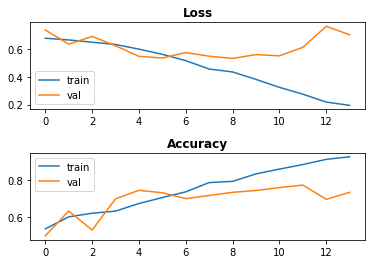



Confusion Matrix, without normalization


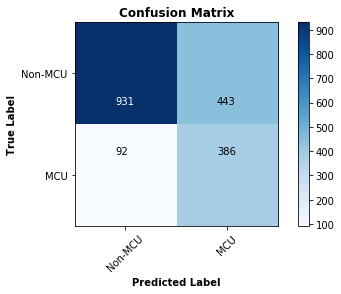



              precision    recall  f1-score   support

     Non-MCU       0.91      0.68      0.78      1374
         MCU       0.47      0.81      0.59       478

    accuracy                           0.71      1852
   macro avg       0.69      0.74      0.68      1852
weighted avg       0.80      0.71      0.73      1852



In [48]:
print(mf.evaluate_test(model_r60_5x5, history_r60_5x5, class_labels, train_images_r60, test_images_r60, train_y_r60, test_y_r60))

### 6x6

In [49]:
model_r60_6x6 = models.Sequential()
model_r60_6x6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Flatten())
model_r60_6x6.add(layers.Dense(64, activation='relu'))
model_r60_6x6.add(layers.Dense(1, activation='sigmoid'))

model_r60_6x6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [50]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r60_6x6 = model_r60_6x6.fit(train_images_r60,
                                    train_y_r60,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r60, val_y_r60),
                                    callbacks=early_stopping)

Train on 3293 samples, validate on 822 samples
Epoch 1/50
3293/3293 [==============================] - 5s 2ms/step - loss: 0.6980 - acc: 0.5454 - val_loss: 0.6126 - val_acc: 0.6691
Epoch 2/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6780 - acc: 0.5776 - val_loss: 0.6393 - val_acc: 0.6302
Epoch 3/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6737 - acc: 0.6016 - val_loss: 0.6364 - val_acc: 0.6898
Epoch 4/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6513 - acc: 0.6271 - val_loss: 0.6774 - val_acc: 0.5596
Epoch 5/50
3293/3293 [==============================] - 5s 2ms/step - loss: 0.6415 - acc: 0.6231 - val_loss: 0.5776 - val_acc: 0.7044
Epoch 6/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6287 - acc: 0.6529 - val_loss: 0.5742 - val_acc: 0.7263
Epoch 7/50
3293/3293 [==============================] - 5s 1ms/step - loss: 0.6000 - acc: 0.6726 - val_loss: 0.5949 - val_acc: 0.6740
Epoch 8/50
3293

Accuracy 
 Train: 0.870, Test: 0.701
Loss 
 Train: 0.290, Test: 0.680 



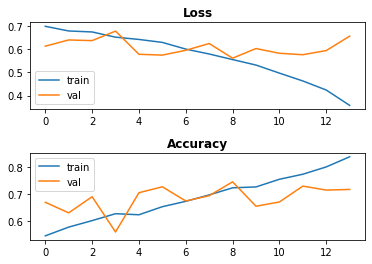



Confusion Matrix, without normalization


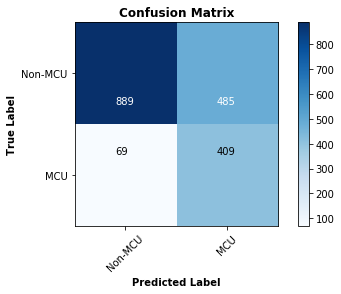



              precision    recall  f1-score   support

     Non-MCU       0.93      0.65      0.76      1374
         MCU       0.46      0.86      0.60       478

    accuracy                           0.70      1852
   macro avg       0.69      0.75      0.68      1852
weighted avg       0.81      0.70      0.72      1852



In [52]:
print(mf.evaluate_test(model_r60_6x6, history_r60_6x6, class_labels, train_images_r60, test_images_r60, train_y_r60, test_y_r60))